In [1]:
import os ; import pathlib as pl ; import flopy ; import matplotlib.pyplot as plt ; import numpy as np; from flopy.utils.lgrutil import Lgr  
from matplotlib.colors import ListedColormap ; from pathlib import Path; from flopy.plot.styles import styles ; import pandas as pd 
from modflow_devtools.misc import get_env, timed ; write=get_env("WRITE", True);run=get_env("RUN", True)
write=get_env("WRITE", True);run=get_env("RUN", True) ; 
plot = get_env("PLOT", True) ; plot_show = get_env("PLOT_SHOW", True) ; plot_save = get_env("PLOT_SAVE", True)

In [2]:
sim_ws = Path("./12_sfr-pindersauer") ; sim_ws.mkdir(exist_ok=True) ; sim_name = "sfr-pindersauer"
exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe' ; workspace = figs_path = sim_ws ; gwf_name = sim_name 
path = 'E:\\15_REPOS\\00_BETAMI\\bin\\data_modflow6-examples\\ex-gwf-sfr-pindersauer'
aux_ws = Path("./_aux")
fpath1 = os.path.join(path,"delr.txt") 
fpath2 = os.path.join(path,"initial_head.txt")      
fpath3 = os.path.join(path,"initial_stage_a.txt")     
fpath4 = os.path.join(path,"initial_stage_b.txt") 
parameters = {"ex-gwf-sfr-pindersauera": {"lambda_val": (-4.779e-2, -0.3608), "leakance":      0.0},
              "ex-gwf-sfr-pindersauerb": {"lambda_val": (-0.1785,   -0.3409), "leakance": 1.42e-04}}   # 4 x

In [3]:
length_units = "meters" ; time_units = "seconds"

nlay = 1  # Number of layers
nrow = 65  # Number of rows
ncol = 15  # Number of columns
delr = "varies"  # Column width ($m$)
delc = 609.61  # Row width ($m$)
top = "varies"  # Top of the groundwater model ($m$)
botm = 0.0  # Bottom of the groundwater model ($m$)
strt = "varies"  # Starting head ($m$)
k11 = 3.048e-3  # Hydraulic conductivity ($m/s$)
ss = 0.1e-6  # Specific storage ($1/s$)
sy = 0.25  # Specific yield (unitless)
nreaches = 65  # Number of reaches
slope = 0.001  # Reach bed slope ($m/m$)
roughness = 0.03858  # Mannings roughness coefficient ($s/m^{1/3}$)
q_base = 509.70  # Upstream inflow base rate ($m^3/s$)
q_amplitude = 141.58  # Upstream inflow amplitude ($m^3/s$)
lambda1 = "varies"  # Amplitude decay constant
lambda2 = "varies"  # Dimensionless wave number
Gamma = 4894.3  # Characteristic length related to the wave number of the water-level disturbance
fr = 3.49e-4  # Characteristic frequency of the system

nper = 1  # Number of periods
nstp = 288  # Number of time steps
dt = 300.0  # Time step length ($s$)
times = np.arange(0.0, 86400.0 + dt, dt)  ; tdis_ds = [(86400.0, nstp, 1.0)]

delr = np.loadtxt(fpath1, dtype=float)

extents = (0.0, delr * ncol, 0.0, delc * nrow)
shape2d = (nrow, ncol)
shape3d = (nlay, nrow, ncol)

# Observation locations
obs_loc = 24.0 * delc  ; obs_ifno = int(obs_loc / delc)

jcol_sfr = 7           ; top = np.repeat(np.linspace(8.675181e01, 4.773705e01, nrow).reshape(nrow, 1), ncol, axis=1)
top[:, jcol_sfr] = np.linspace(6.065575e01, 2.164100e01, nrow)

inflows = q_base + q_amplitude * np.sin(2.0 * np.pi * times / 18000.0)   ; ts_data = [(t, q) for t, q in zip(times, inflows)]

strt = np.loadtxt(fpath2, dtype=float)    ; stage = np.loadtxt(fpath3, dtype=float)
parameters["ex-gwf-sfr-pindersauera"]["stage"] = [(ifno, float(stage[ifno])) for ifno in range(nreaches)]
stage = np.loadtxt(fpath4, dtype=float)
parameters["ex-gwf-sfr-pindersauerb"]["stage"] = [(ifno, float(stage[ifno])) for ifno in range(nreaches)]

upstream_frac = [0.0] + (nrow - 1) * [1.0] ; nconn = [1] + (nrow - 2) * [2] + [1]
sfr_conn = ([(0, -1)]+ [(idx, idx - 1, -(idx + 1)) for idx in range(1, nrow - 1)]+ [(nrow - 1, (nrow - 2))])
sfr_spd = {0: [(0, "inflow", "inflow")]}

In [4]:
def analytical_solution(lambdas, x, t):
    return q_base + q_amplitude * np.exp(lambdas[0] * x / Gamma) * np.sin(fr * t + lambdas[1] * x / Gamma)

In [5]:
def build_models(sim_name, lambda_val, leakance, stage):
    sim_ws = os.path.join(workspace, sim_name)
    name = sim_name.replace("pindersauer", "ps")
    sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(sim)
    gwf = flopy.mf6.ModflowGwf(sim, modelname=name)
    flopy.mf6.ModflowGwfdis(gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm)
    flopy.mf6.ModflowGwfnpf(gwf,icelltype=1,k=k11)
    flopy.mf6.ModflowGwfsto(gwf,iconvert=1,sy=sy,ss=ss,transient={0: True})
    flopy.mf6.ModflowGwfic(gwf, strt=strt)
    oc = flopy.mf6.ModflowGwfoc(gwf, printrecord=[("budget", "all")])

    pak_data = [(ifno,0,ifno,jcol_sfr,delc,delr[jcol_sfr],slope,top[ifno, jcol_sfr],1.0,leakance,roughness,nconn[ifno],
                 upstream_frac[ifno],0,) for ifno in range(nreaches)]
    sfr = flopy.mf6.ModflowGwfsfr(gwf,print_input=True,print_flows=True,storage=True,nreaches=nreaches,packagedata=pak_data,
                                  connectiondata=sfr_conn,initialstages=stage,perioddata=sfr_spd,pname="sfr-1")
    sfr.ts.initialize(filename=f"{name}.sfr.ts",timeseries=ts_data,time_series_namerecord=["inflow"],
                      interpolation_methodrecord=["linearend"])
    fname = f"{name}.sfr.obs"
    sfr_obs = {f"{fname}.csv": [("inflow-ext", "ext-inflow", (0,)),("inflow", "inflow", (obs_ifno,)),
                                ("outflow", "outflow", (obs_ifno,)),("stage", "stage", (obs_ifno,)),("depth", "depth", (obs_ifno))]}
    sfr.obs.initialize(filename=fname, print_input=True, continuous=sfr_obs)
    return sim
def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)
@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent)
    assert success, buff

def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]  ; params = parameters[key].copy() ; sim = build_models(key, **params)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
scenario(0)  ; scenario(1)  # Run without leakage. / # Run with leakage.

run_models took 1859.03 ms
run_models took 2793.66 ms


In [6]:
def plot_observations(sim_list, silent=True):
    colors = ("blue", "black")  ; labels = ("no leakage", "leakage")
    markers = ("s", "o")        ; mosaic = [["a"], ["a"], ["a"], ["a"], ["b"], ["b"], ["b"], ["b"], ["c"]]

    analytical = []
    for key, value in parameters.items():
        lambda_val = value["lambda_val"] ; analytical.append(analytical_solution(lambda_val, obs_loc, times) - q_base)

    with flopy.plot.styles.USGSPlot():
        fig, axs = plt.subplot_mosaic(mosaic, sharex=False, figsize=(7, 5), layout="constrained")

        for key in ("a", "b"):
            ax = axs[key] ; ax.set_xlim(0, 24) ; ax.set_xticks([0, 6, 12, 18, 24]) ; 
            if key == "a":
                ax.set_xticklabels([])

        for idx, sim in enumerate(sim_list):
            obs = sim.get_model().sfr.output.obs().get_data()  ; obs["totim"] /= 3600.0
            label = labels[idx]

            ax = axs["a"] ; ax.set_ylim(-1.25, 1.25) ; b = obs["DEPTH"]
            ax.plot(obs["totim"], b - b.mean(), color=colors[idx], lw=0.75, label=label)
            ax.axhline(0.0, color="0.5", lw=0.5, label=None) ; ax.set_ylabel("Relative stage, m")  ; flopy.plot.styles.heading(ax, idx=0)

            ax = axs["b"] ; ax.set_ylim(-150, 150) ; q = -obs["OUTFLOW"]
            ax.plot(obs["totim"], q - q_base, color=colors[idx], lw=0.75, label=label)
            ax.plot((times / 3600)[::3],analytical[idx][::3],color=colors[idx],marker=markers[idx],mfc="none",ms=4,lw=0.0,label=f"{label}-analytical")
            ax.axhline(0.0, color="0.5", lw=0.5, label=None) ; ax.set_ylabel("Relative streamflow, m$^3$/s") ; flopy.plot.styles.heading(ax, idx=1)

        ax = axs["b"] ; leg_handles, leg_labels = ax.get_legend_handles_labels() ; ax.set_xlim(0, 24) ; ax.set_xlabel("Simulation time, hours")

        ax = axs["c"] ; ax.axis("off") ; flopy.plot.styles.graph_legend(ax, leg_handles, leg_labels, ncol=2, loc="center")
        fig.align_labels()
        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-observations.png"
            fig.savefig(fpth)


def plot_results(silent=True):
    sim_list = []
    for key in parameters.keys():
        sim_ws = os.path.join(workspace, key)
        sim_name = key.replace("pindersauer", "ps")
        sim_list.append(flopy.mf6.MFSimulation.load(sim_ws=sim_ws))
    plot_observations(sim_list, silent=silent)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package npf...
    loading package sto...
    loading package ic...
    loading package oc...
    loading package sfr...
  loading solution package ex-gwf-sfr-psa...
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package npf...
    loading package sto...
    loading package ic...
    loading package oc...
    loading package sfr...
  loading solution package ex-gwf-sfr-psb...


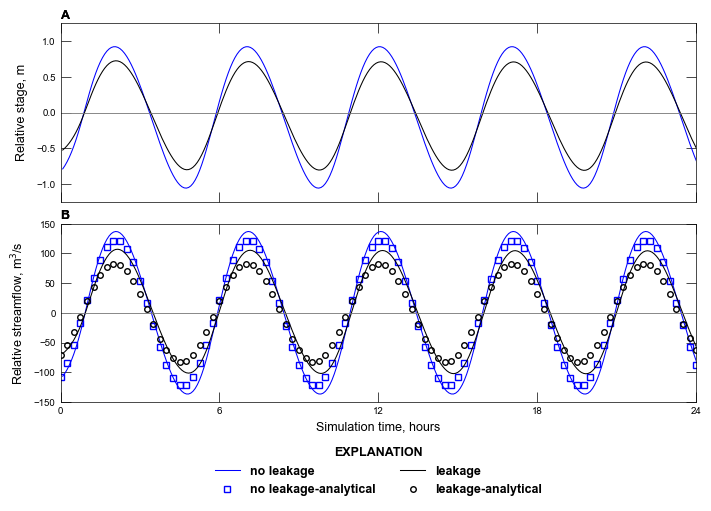

In [7]:
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]  ; params = parameters[key].copy() ; sim = build_models(key, **params)
# scenario(0)  ; scenario(1)  # Run without leakage. / # Run with leakage.
if plot:
    plot_results()